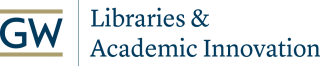

# Web Scraping: What You Need to Know

Web scraping is a technique for extracting data from web pages using code. While great tools exist in Python and other programming languages, scraping modern websites poses many challenges. This workshop will help you understand the structure of web pages and identify the features of a website that may make scraping easy, hard, or (in some cases) impossible. We'll walk through some examples together, using Python and the tools available in your web browser. Some prior familiarity with Python or another programming language is highly recommended.

**Instructors**: Matt Mihalik & Dolsy Smith

**Date & Time**: Friday, October 4, 2:30 - 4:30 pm

**Location**: Gelman Library, Room 324 and [via Zoom](https://gwu-edu.zoom.us/my/laiworkshops)

**Notebook link**: [https://go.gwu.edu/web-scraping-workshop](https://go.gwu.edu/web-scraping-workshop)

## Outline

1. [A best-case scenario](#A-Best-Case-Scenario)
2. [Bot or Not](#Bot-or-Not) 
3. [Anatomy of an HTTP request](#Anatomy-of-an-HTTP-Request)
4. [How to act less like a bot](#How-to-Act-Less-Like-a-Bot)
5. Other modes of bot detection
6. [Hidden API's](#Hidden-APIs)
7. Good citizen scraping

## A Best-Case Scenario 

At its simplest, a web page is a bunch of HTML tags enclosing some text (and maybe an image or two). Such **static** pages live on a web server (or else they are generated by the web server in response to an **HTTP request**). We call them _static_ because they don't change much. You might think of them like a Word document or PDF that someone sends you as an email attachment.

To scrape such pages, we need just a few tools.

But since nearly all web pages are written in HTML, as a minimum, it's helpful to have some sense of what **HTML** _is_.

### A very brief HTML primer

Take a look at this snippet of HTML. How would you describe the structure you see?

![sched-class-snippet.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/html-1.png?raw=true)

<details>
    <summary style="font-size:14pt">Click for a Hint</summary>
    <p></p>
    <p>Here are some things to keep in mind about HTML for the purposes of web scarping.</p>
    <ul>
        <li>HTML provides a set of <em>formatting</em> tags. The tags are, for the most part, not intended to describe document structure or content.</li>
        <li>HTML tags are <em>nested</em>. In the example, the <code>&lt;div&gt;</code> tags create three levels of container. The innermost container contains a <code>&lt;ul&gt;</code> tag, which creates an unordered (unnumbered) list.</li>
        <li>Within each <code>&lt;li&gt;</code> tag, which encloses a list element, the <code>&lt;a&gt;</code> tag creates a hyperlink.</li>
        <li>The URL to which the hyperlink leads is in the <code>href</code> <b>attribute</b> inside the <code>&lt;a&gt;</code> tag. An attribute allows additional data to be enclosed in an HTML tag. The data in attributes does not display, but it can be used by the browser to affect display of the page, or to provide other information (in this case, the URL for a link).</li>
        <li>The text that appears on the page -- in the labels on hyperlinks -- is enclosed within the <code>&lt;a&gt;</code> tags: <code>Academy for Classical Acting</code> and <code>Accountancy</code>.</li>
    </ul>
</details>

The snippet above is from the [GW Schedule of Classes](https://my.gwu.edu/mod/pws/subjects.cfm?campId=1&termId=202303). In what follows, we'll scrape this page to extract some course information. We'll use Python tools to do this.

There are two steps to scraping a web page (in the best-case scenario). 

### Step 1: Download the content

We'll use a Python library called `requests` to retrieve the HTML of this and other pages from the web. Many Python distributions come with requests pre-installed, but if you get a `ModuleNotFound` error running the following commands, run `!pip install requests` in a cell by itself, and then run the commands again.

In [1]:
import requests

To scrape page, we start with a URL. In this case, the URL contains **parameters**, which tell the server to return specific kinds of information depending on the values of the parameters (campus and semester). 

Note that the presence of URL parameters doesn't mean that content is being **dynamically** loaded (i.e., in response to a user's actions in the browser). In this case, all the HTML on the page is being sent from the server at one time. That's part of what makes it a "best-case" scenario for scraping.

In [2]:
depts_url = 'https://my.gwu.edu/mod/pws/subjects.cfm'
params = {'campus_id': '1', # Main Campus
            'term_id': '202303'}

With our URL and params in place, we can make our first request.

In [3]:
depts_page = requests.get(depts_url, params=params)

Here `depts_page` is an HTTP response object. The value of `200` means that the request succeeded (returned the expected content). The content of the page -- the HTML -- is available under the `.text` property of the response object.

In [ ]:
depts_page

In [ ]:
depts_page.text

### Step 2. Parse the HTML

To scrape web pages written in HTML, we target the HTML tags using a tool called a **parser**. The parser recognizes valid HTML and allows us to extract the information enclosed in the tags: for instance, the labels and URL's in a list of departments. 

Before parsing this page with Python, we'll step away from the notebook for a moment to look at some browser tools that can help us identify which elements to target.

We'll use a library call [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to parse the HTML of this page. You may need to install it first, which you can do by running `!pip install beautifulsoup4` in a code cell below.

In [4]:
from bs4 import BeautifulSoup


In [5]:
soup = BeautifulSoup(depts_page.text, features="html.parser")

We can use the nested structure of HTML to target elements that are **children** (nested under) other elements. So if we want to retrieve all hyperlinks (`<a>` tags) inside the `<div>` with the `class` attribute value of `subjectsMain`, we can write the following:

In [ ]:
soup.find("div", class_="subjectsMain").find_all("a")

The `find_all` method returns a Python list of BeautifulSoup objects, one for each HTML element that matches our query. 

In web scraping, we usually don't care about the HTML elements themselves; we want the text or data inside them. In this case, let's extract all of the `href` values, since each `href` is a link to a page listing the courses in a given department.

In [6]:
links = [l['href'] for l in soup.find("div", class_="subjectsMain").find_all("a")]

In [28]:
links = set(links)

Note that `links` is a list of Python strings, each of which corresponds to a single URL. 

We use the Python `set()` function to dedupe the list of links -- always a good idea when scraping data from the web, since you never know what might be duplicated. 

The URL's in `links` are not complete: note that they're missing the `gwu.edu` domain. But we can use them to reconstruct a complete URL to a course listings page by simply appending the string `'https://my.gwu.edu/mod/pws/'` to the beginning of each URL in `links`.

That way, we can automate scraping all the course schedule pages for the Fall 2023 semester, main campus. 

But before we proceed, it behooves us to look at the site's **robots.txt** file. Since the `mod/pws` directory is allowed, we can proceed to scrape knowing that we're not in violation of the website's policies.

#### Challenge

Can you write some Python code to retrieve all of the course-listing pages from the partial URL's in `links`? For now, just use the `requests` library to `get()` each page and store the page text in a list called `course_listings`. The following code stub will help you get started. 

In [ ]:
course_listings = []
for link in links:
    pass

<details>
    <summary style="font-size:14pt">Click for a Solution</summary>
<pre>
<code>
course_listings = []
for link in links:
    course_page = requests.get('https://my.gwu.edu/mod/pws/' + link)
    course_listings.append(course_page.text)
</code>
</pre>
</details>

Now that we have downloaded the HTML for all the course listings, we could use BeautifulSoup to extract the course schedules from each HTML document. We won't step through that together in the interest of time, but see the [bonus material](#Bonus-Material) at the bottom of this notebook for a detailed example.

## Bot or Not

Each course entry on the course schedules pages includes a link to the course's page on eFollet.com, where you can see the assigned textbooks for that course. For instance, here's the eFollet page for [BISC 2450](https://www.bkstr.com/georgewashingtonstore/follett-discover-view/booklook?shopBy=discoverViewCourse&bookstoreId=122&termId=202303&divisionDisplayName=&departmentDisplayName=BISC&courseDisplayName=2450&sectionDisplayName=10).

So what happens if we try to request that page using the same methods as above?

In [ ]:
books = requests.get('https://www.bkstr.com/georgewashingtonstore/follett-discover-view/booklook?shopBy=discoverViewCourse&bookstoreId=122&termId=202303&divisionDisplayName=&departmentDisplayName=BISC&courseDisplayName=2450&sectionDisplayName=10')

In [ ]:
books

In [ ]:
books.text

Our request returns with a `403` status code, which is not a good sign. (Only something in the `200` range indicates a successful request.) And while the response does contain HTML, it's clearly not what we were expecting. So what went wrong?

It's time to talk a bit about why websites (and their owners) may not want you to scrape their data, what kinds of other automation they might be trying to protect themselves from, and how that affects your ability to scrape websites.

We'll also look more closely at the browser tools to learn more about the structure of HTTP requests.

## Anatomy of an HTTP Request

In the demonstration just now, we saw that web browsers add a lot of information via the **headers** of HTTP requests. This information is typically invisible to the end user, but websites can use it (or exploit it) to do things like track their users and, more to the point as far as web scraping is concerned, try to determine whether a user is a person or a bot.

(When we say "person," we mean "a person using a web browser to browse pages one at a time, usually for a purpose that does _not_ involve gathering large amounts of data from the site.")

By default, our requests made with the Python `requests` library honestly report (via the `User-Agent` header) their origin in a Python module. But if we are willing to fib a little, we can modify this behavior to foster the impression that the request is coming from a web browser.

### Request Headers

An HTTP request header is just a key-value pair, separated by a colon in the textual representation of the HTTP request. We can represent this in Python using a **dictionary**. 

The `requests.get` method takes an optional `headers` argument, which expects just such a dictionary. In the code below, we'll construct a deceptive header to bypass some bot detection at a sandbox site designed to help you practice web scraping.

In [ ]:
scrape_site_url = 'https://www.scrapethissite.com/pages/advanced/?gotcha=headers'
requests.get(scrape_site_url)

## How to Act Less Like a Bot

Without any custom headers, we get a `400`, meaning the web server has refused to comply with our request. 

#### Challenge

Using your browser tools when visiting the URL above, see if you can populate the `User-Agent` field in the dictionary below with a value that your web browser uses.

In [ ]:
headers = {'User-Agent': '', # Insert the brower's User-Agent string between the single quotes
            'Accept': 'text/html'}

<details>
    <summary style="font-size:14pt">Click for a Solution</summary>
<pre>
<code>
# The User-Agent string from my Firefox browser on Mac OS X
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36',
            'Accept': 'text/html'}
</code>
</pre>
</details>

In [ ]:
r = requests.get('https://www.scrapethissite.com/pages/advanced/?gotcha=headers', headers=headers)

In [ ]:
r

With our **spoofed** `User-Agent` header, the site now accepts our request. This method can be one way to evade, or partially evade, bot detection, depending on how the web server is configured. Including other headers (derived from inspecting the successful requests made by your browser) may, in certain instances, also help. 

There's no one recipe for by-passing every form of bot detection that uses headers, nor is there even a way (apart from trial and error) to determine whether a site is using headers to filter traffic. But it's a relatively low-effort way to improve the odds that your web scraping will pass undetected. 

## Hidden APIs

Bot detection isn't the only thing that makes web scraping a challenge. The dynamic structure of many sites also makes them hard to scrape, even if the site isn't actively trying to deter bots. Contemporary web developers often build so-called **single-page apps**, where the HTML is generated in the browser by Javascript (as opposed to generated on the server). 

The problem these sites pose for scraping is this: an approach that makes a single HTTP request to a page -- such as we used above -- via a library like Python's `requests`, has no ability to **render** HTML; it can only **parse** it. If the HTML that you see when you visit the page with your browser requires **client-side Javascript** to be rendered, your Python script is at a loss: it can't do anything with Javascript. Much in the way that a `.docx` file can be opened only by certain kinds of applications, such web pages are intended to be viewed only by modern web browsers. 

For these cases, you may need the full capability of a web browser to scrape the site. Projects like [Selenium](https://selenium-python.readthedocs.io/index.html) provide tools for automating a web browser with Python code. But fair warning: these approaches can be quite tedious to implement, since it often becomes necessary to control for very fine-grained browser behavior that responds to the particular nuances of the site. A working knowledge of Javascript is often useful, in addition to Python and HTML.

Fortunately, it's not always necessary to go that route when dealing with a dynamic web page. Such web pages still have to get their data from somewhere, even if they're generating the HTML on the spot. And since it's the data we're interested it, not the HTML, if we can identify the data source, we might be able to bypass the web page altogether!

In what follows, we'll see how to access the data source for pages of results on the [Nintendo e-shop](https://www.nintendo.com/store/). 

### Replicating an XHR request with Python

Once we've identified the data source for the search results with the browser tools, we can try to replicate it in Python. 

This request is a **POST** request, meaning that instead of two parts (URL + parameters and headers), it has three, the third being some data that we submit to the server for processing. 

We'll recreate each part in turn before putting it all together.

#### Assembling the headers

The headers we can copy directly from the `Headers` panel in the browser's network inspector. Just make sure you copy the **request** heades, not the response headers (which, at least on Firefox, are listed first).

Since it's basically a multiline string, in Python we can paste the headers text between triple quotation marks.

In [ ]:
nintendo_headers = '''
Host: u3b6gr4ua3-dsn.algolia.net
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/117.0
Accept: */*
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate, br
x-algolia-api-key: a29c6927638bfd8cee23993e51e721c9
x-algolia-application-id: U3B6GR4UA3
content-type: application/x-www-form-urlencoded
Content-Length: 301
Origin: https://www.nintendo.com
Connection: keep-alive
Referer: https://www.nintendo.com/
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: cors
Sec-Fetch-Site: cross-site
Pragma: no-cache
Cache-Control: no-cache
'''

The `headers` argument to `requests.post` needs to be a dictionary. But since the headers string is a sequence of key-value pairs, delimited by colons, we can convert it to a dictionary like so:

In [ ]:
nintendo_headers = dict([h.split(sep=': ', maxsplit=1) for h in nintendo_headers.split('\n') if h])

In [ ]:
nintendo_headers

#### URL & parameters

The URL can also be copied from the browser's network inspector. The parameters are already encoded as part of the URL.

In [ ]:
nintendo_url = 'https://u3b6gr4ua3-dsn.algolia.net/1/indexes/*/queries?x-algolia-agent=Algolia%20for%20JavaScript%20(4.19.0)%3B%20Browser%3B%20JS%20Helper%20(3.13.5)%3B%20react%20(17.0.2)%3B%20react-instantsearch%20(6.40.3)'

#### Request body

The **body** of the request, in this case, contains what's called **form-encoded data**, which simply means that it originated in a web form (the advanced search). We can simply copy and paste; it's already in JSON format, so we don't need to do anything additional to it. 

In [ ]:
nintendo_json = {"requests":[{"indexName":"store_game_en_us","params":"analytics=true&attributesToHighlight=%5B%22description%22%5D&clickAnalytics=true&facetingAfterDistinct=true&facets=%5B%22*%22%5D&filters=&highlightPostTag=%5E*&highlightPreTag=%5E*%5E%5E&hitsPerPage=40&maxValuesPerFacet=100&page=0&tagFilters="}]}

Now let's make a request!

In [ ]:
r = requests.post(nintendo_url, headers=nintendo_headers, json=nintendo_json)

In [ ]:
r

Remember that this response should not be HTML. We're expecting **JSON**. And to access the JSON, we first need to parse it. Fortunately, the `requests` library has us covered.

In [ ]:
nintendo_data = r.json()

In [ ]:
nintendo_data

The nice thing about JSON data is that we don't have to bother with HTML parsers like BeautifulSoup. When we parse the data with the `.json()` method, it becomes a regular Python object: in this case, a (rather nested) list of dictionaries.

In [ ]:
nintendo_data['results'][0]['hits'][0]['title']

What we've done is identified the **data source** used by the Javascript on the page to generate the HTML. By going directly to the data source, we can dramatically simplify our scraping code. This approach is often referred to as using a **hidden API** -- hidden because not publicly advertised, hidden from users behind a curtain of HTML and Javascript.

Note that we reproduced the exact request made by our browser, including the headers, in order to try to forestall any bot detection (which may or may not be present). 

Another advantage of this approach, in this case, is that getting data from subsequent pages of results is relatively straightforward. All we have to do is modify the `page=0` parameter in the JSON request data.

If we use Python string formatting, we can even do this in a `for` loop. Let's get the first three pages of results.

In [ ]:
param_str = "analytics=true&attributesToHighlight=%5B%22description%22%5D&clickAnalytics=true&facetingAfterDistinct=true&facets=%5B%22*%22%5D&filters=&highlightPostTag=%5E*&highlightPreTag=%5E*%5E%5E&hitsPerPage=40&maxValuesPerFacet=100&page={page_num}&tagFilters="

In [ ]:
results = []
for i in range(3):
    nintendo_json['requests'][0]['params'] = param_str.format(page_num=i)
    r = requests.post(nintendo_url, headers=nintendo_headers, json=nintendo_json)
    data = r.json()
    results.extend(data['results'][0]['hits'])

In [ ]:
len(results)

## Bonus Material

### Scraping Course Schedules

If you've run all the code above and completed the challenge at the end of the section [Step 2. Parsing the HTML](#step-2-parse-the-html), you should have a variable called `course_listings` that is a list of the pages associated with each department in the GW Schedule of Classes (Main Campus, Fall 2023). 

To extract the schedules from these pages, we'll need to parse each page using BeautifulSoup. 

Let's say we're interested in extracting the following information:
 - the days and times each course meets, along with 
 - the dept code,
 - course number,
 - course title, and
 - section number.

Looking at the HTML in the browser's inspector for [this page](https://my.gwu.edu/mod/pws/courses.cfm?campId=1&termId=202303&subjId=ASTR), which shows the course schedules for the Astronomy department, we can see that each course is an HTML [table](https://developer.mozilla.org/en-US/docs/Learn/HTML/Tables/Basics) with a `class` attribute of `courseListing`. (The `<table>` element has multiple classes, separated by spaces, but we can use the first one, which seems the most relevant.

Within the `<table>` element, the schedule information is in the first row (`<tr>`). 

![Screenshot 2023-09-15 at 9.11.53 AM.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/html-2.png?raw=true)

Specifically, the relevant data points we want are in the 3rd, 4th, 5th, and 9th cells (the `<td>` elements) within the first `<tr>` element of each table.

Below is how we can target those elements for a single page.

**Step 1**: Parse the HTML for the page

In [11]:
course_page = BeautifulSoup(course_listings[0], features="html.parser")

**Step 2**: Extract all the `<table>` elements that have the `courseListing` class attribute. (There should be one per course).

In [12]:
tables = course_page.find_all('table', class_='courseListing')

**Step 3**: Now we want to extract the text from the relevant cells from each table. 

Within the `for` loop below, the `table.find('tr')` method call extracts the first row from each table, and the call to `find_all('td')` extracts all of the cells within that row. 

Then we use Python indexing to target the particular table cells we want, and access the `text` attribute to extract the text from those elements. (Remember that in web scraping, we usually want to extract the text from elements and attributes; we don't really care about the elements or attributes themselves, except insofar as they lead us to the desired text, which is ultimately the content of the web apge.)

We wrap each collection of course information in a Python dictionary and `append` that dictionary to a list.

In [13]:
courses = []
for table in tables:
    cells = table.find('tr').find_all('td')
    course = {'course_code': cells[2].text.split(),
            'section': cells[3].text,
            'title': cells[4].text,
            'times': cells[8].text.split('AND')}
    courses.append(course)

Now `courses` should contain the information from the course listings for the first department in our list.

In [ ]:
courses

**Step 4:** Now we can repeat this process for each page in the `course_listings` list. 

It will be cleaner to refactor the code above into a Python function, so that we can simply call that function once per page.

In [8]:
def scrape_course_info(page):
    soup = BeautifulSoup(page, features="html.parser")
    tables = soup.find_all('table', class_='courseListing')
    courses = []
    for table in tables:
        cells = table.find('tr').find_all('td')
        course = {'course_code': cells[2].text.split(),
                'section': cells[3].text,
                'title': cells[4].text,
                'times': cells[8].text.split('AND')}
        courses.append(course)
    return courses

Now we can loop over `course_listings`, calling our function on each pass through the list. We use the `extend` method to add the results of each call to `scrape_course_info` to one big list, which will hold the course info for all course pages (across all departments).

In [31]:
all_courses = []
for listing in course_listings:
    courses = scrape_course_info(listing)
    all_courses.extend(courses)

Now we have the information for 1,650 courses!

In [32]:
len(all_courses)

1650

### Bonus Bonus! Getting multiple pages of course listings

We're technically not finished yet, because some course listings extend across multiple pages. In our initial scraping, we retrieved only the first page of results for each department.

For example, look at the page for [Arabic](https://my.gwu.edu/mod/pws/courses.cfm?campId=1&termId=202303&subjId=ARAB). Note the (rather small) `Next Page >>` link on the right-hand side of the page (above the actual course listings). There's also an element labeled `Result Page` that has a link to each page. (In this case, there are only two.) 

![Screenshot 2023-09-15 at 9.33.13 AM.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/sched-1.png?raw=true)

When you encounter paginated results on a web site, there are a few different possibilities. 

1. In the most straightforward case (for scraping purposes), each page of results is a separate page on the server. You can often tell if this is the case by visiting the next page of results and noting whether the URL changes. If the URL changes -- for instance, by the presence of a parameter indicating the page number -- then retrieving all of the results pages is only a matter of making successive requests to the site, updating the URL accordingly. **Unfortunately, for the GW Schedule of Classes, this is not the case.** The URL of the course listings is the same, regardless of which page of results one is visiting.
   
2. Another possibility is that the page uses Javascript to reload the page with new data. As it turns out, that's how pagination works on the GW Schedule of Classes. If you look closely, when you mouse over the `Next Page >>` link or the `2` link in your browser, you might see a little flag at the bottom of the window indicating that this link will trigger some Javascript. This indicates that going to a specific page of results calls a Javascript function.

3. The third possibility, which is subtly different from the second, is that the Javascript function doesn't reload the page but instead retrieves some data from the server and uses that data to update the page. The difference is that in this case, because the HTML is updated by the browser after the page has already been loaded, we can't use Python to parse the updated HTML (without relying on something like Selenium -- see the section on [Hidden API's](#hidden-apis) above.

![Screenshot 2023-09-15 at 9.41.53 AM.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/sched-2.png?raw=true)

In this case, using the `Network` tab on our browser's inspector, we can see that, when we click the `2` link to go to the second page, the first request made is a `POST` request which returns HTML, not JSON or some other format. This indicates that the Javascript function is actually loading a new page (not just loading data and adding it to the current page).

![Screenshot 2023-09-15 at 10.03.40 AM.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/inspector-1.png?raw=true)

And if we look at the `Request` panel when selecting the above request, we can see how the page number was passed to the server. The page number -- `2` in the example below -- was associated with a `pageNum` key in the `POST` request to the server. 

We can replicate this `POST` request in order to get subsequent pages of results.

![Screenshot 2023-09-15 at 10.06.31 AM.png](https://github.com/gwu-libraries/gwlibraries-workshops/blob/master/web-scraping/inspector-2.png?raw=true)

One approach would be as follows:

We already have the first page of each set of course schedules -- in our `course_listings` variable above. We also have the URL of each of these pages in our `links` variable. (The length and order of both lists should be the same, since we visited each link in order to obtain the pages in `course_listings`, and we haven't reordered or changed either list. 

So for each page in `course_listings`, we can do the following:

1. Extract any links on the page having for their destination `javascript:goToPage`. (That will be in the `href` attribute of the `<a>` tag.)
2. For all links on the page where the argument to `goToPage` is greater than `1` (we already have the first page, so we don't need to get it again), visit the page URL (stored in the `links` list), passing the page number in a `POST` request.
3. Scrape these pages and add them to our `courses` list, using our function defined above.

In [33]:
# We will use a regular expression to identify those <a> tags that contain a certain string in their href attributes
# For more on regular expressions, see the Python documentation: https://docs.python.org/3/library/re.html
import re
# The Python zip() function is a handy tool for looping over multiple lists in parallel
for page, url in zip(course_listings, links):
    # Since course_listings contains the raw HTML of each page, we need to parse it first
    page_html = BeautifulSoup(page, features="html.parser")
    # Find all a tags that match a given string
    page_nums =  page_html.find_all('a', href=re.compile('javascript:goToPage')) 
    # Loop over each matching element
    for page_num in page_nums:
        # We don't need to get the first page (we already have it)
        if page_num.text != '1':
            page_data = requests.post('https://my.gwu.edu/mod/pws/' + url, 
                              headers={'Content-Type': 'application/x-www-form-urlencoded'}, # This special head tells the server to expect form data
                              data=f"pageNum={page_num.text}")  # Because it's form-urlencoded, we pass the data as a string
            next_page_courses = scrape_course_info(page_data.text)
            all_courses.extend(next_page_courses)